
# Network Science (HS21)
## Assignment 7

### Ben     Murphy          16-714-925
### Florian Rüegsegger      14-714-737

#### The excercise was solved together in person



In [437]:
import networkx as nx
import numpy as np
from numpy.typing import ArrayLike
from typing import Tuple, List
import matplotlib.pyplot as plt 
import seaborn as sns

# A07.1

In [438]:
def compute_eigen(data: ArrayLike) -> Tuple[float, float]:
    return np.linalg.eig(data)

def marcenko_pasture_law(Q: float) -> ArrayLike:

    sigma = 1
    lambda_max = sigma**2 * (1 + (1 / Q) + 2 * np.sqrt(1 / Q))
    lambda_min = sigma**2 * (1 + (1 / Q) - 2 * np.sqrt(1 / Q))
    space = np.linspace(lambda_min,lambda_max,50)
    print(f"Q: {Q}")
    print(f"lambda max: {lambda_max}, lambda min: {lambda_min}")

    p = Q / (2 * np.pi * sigma**2) * np.sqrt((lambda_max - space) * (space - lambda_min)) / space

    return space,p

def plot_hist(eigen, marcenko_space,marcenko, label):
    print(f"found eigenvalues greater than 5: {eigen[eigen>5]}")
    marcenko_scaler =  np.max(marcenko_space) - np.min(marcenko_space)
    
    if marcenko_scaler>=1:
        marcenko/=marcenko_scaler
    else:
        marcenko*=marcenko_scaler
    bins = np.arange(0, np.max(eigen),1)
    sns.histplot(eigen, label="eigen",stat="density", bins=bins)
    plt.plot(marcenko_space,marcenko, label="marcenko")
    plt.title(f"Eigen hist with marcenko_superimposed for {label}")
    plt.xlabel("p(lambda)")
    plt.ylabel("lambda")
    plt.legend()
    plt.show()

    increase = 0.5
    eigen = eigen[eigen<5]
    bins = np.arange(0,5,increase)
    sns.histplot(eigen/increase, bins=bins, stat="density", label="eigen")
    plt.plot(marcenko_space,marcenko, label="marcenko")
    plt.title(f"Eigen hist with marcenko_superimposed for {label} focused on lambda<5")
    plt.ylabel("p(lambda)")
    plt.xlabel("lambda")
    plt.legend()
    plt.show()

def denoise_correlation_matrix(values: ArrayLike, vectors: ArrayLike, Q) -> ArrayLike:
    sigma = 1
    lambda_max = sigma**2 * (1 + (1 / Q) + 2 * np.sqrt(1 / Q))
    values[values<lambda_max] = 0.5
    
    values = values / np.sum(values)
    D = np.diag(values)


    denoised = vectors @ D @ np.linalg.inv(vectors)
    
    denoised_diag = 1 / np.sqrt(np.diag(denoised))
    D = np.zeros(denoised.shape)
    np.fill_diagonal(D,denoised_diag)

    rescaled_denoised = D @ denoised @ D
    print(rescaled_denoised.shape)
    return rescaled_denoised

def solve_s01(data: ArrayLike, Q: float,label: str):
    values, vectors = compute_eigen(data)
    
    space,p = marcenko_pasture_law(Q)
    plot_hist(values, space,p, label)
    
    denoised = denoise_correlation_matrix(values, vectors, Q)
    return denoised


In [439]:
h1 = np.load("data/cormat_1h.npy")
m1 = np.load("data/cormat_1m.npy")
with open("data/stocknames.txt", "r") as f:
    stocknames = [name.replace("\n","") for name in f.readlines()]

Q: 200.8969
lambda max: 1.146082994368982, lambda min: 0.8638723608405807
found eigenvalues greater than 5: [30.15967999]


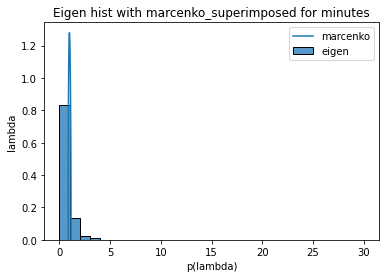

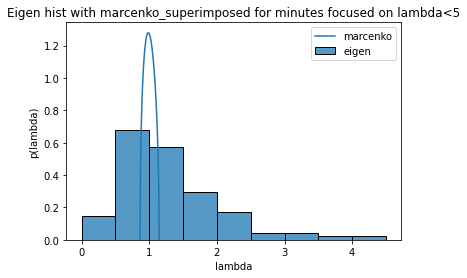

(97, 97)
Q: 3.6289
lambda max: 2.3254524463713677, lambda min: 0.22567875041002616
found eigenvalues greater than 5: [31.02783574  6.11462818]


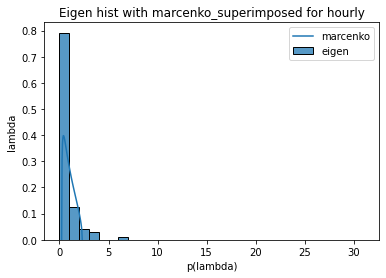

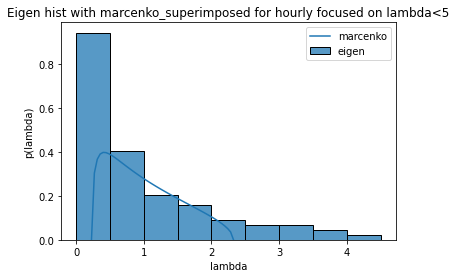

(97, 97)


In [440]:
denoised_min = solve_s01(m1, 200.8969,"minutes")
denoised_hour = solve_s01(h1, 3.6289,"hourly")


# A07.2

In [442]:
from networkx.algorithms.tree.mst import minimum_spanning_tree

In [443]:
def plot_stock_scatter(minutes: ArrayLike, hours: ArrayLike):
    plt.scatter(minutes, hours)
    plt.title("Denoised")
    plt.xlabel("denoised minutes corr matrix")
    plt.ylabel("denoised hour corr matrix")
    plt.show()

def create_minimum_spanning_tree(data: ArrayLike, labels: List[str]):
    distance = np.sqrt(2*(1-data))
    distance = np.nan_to_num(distance)
    graph = nx.from_numpy_array(distance)
    mst = minimum_spanning_tree(graph,weight="weight")
    labels = {i:labels[i] for i in range(len(labels))}
    nx.set_node_attributes(mst, values=labels, name="ticker")
    return mst
    #degrees = nx.degree(mst)
    #return degrees

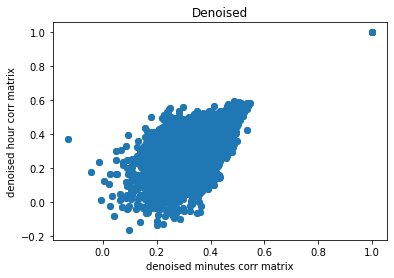

In [444]:
plot_stock_scatter(denoised_min,denoised_hour)

In [445]:
mst_min = create_minimum_spanning_tree(denoised_min,stocknames)
mst_hour = create_minimum_spanning_tree(denoised_hour, stocknames)


/tmp/ipykernel_649517/1146850649.py:9: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt(2*(1-data))


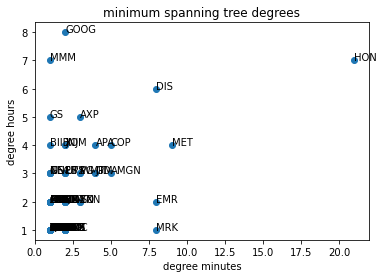

In [446]:
degrees_min = nx.degree(mst_min)
degrees_min = [i[1] for i in degrees_min]
degrees_hour = nx.degree(mst_hour)
degrees_hour = [i[1] for i in degrees_hour]
fig,ax = plt.subplots()
ax.scatter(degrees_min,degrees_hour)
for i, txt in enumerate(stocknames):
    ax.annotate(stocknames[i], (degrees_min[i], degrees_hour[i]))
plt.title("minimum spanning tree degrees")
plt.xlabel("degree minutes")
plt.ylabel("degree hours")
plt.show()

# A07.3

## 3.1
Yes
We can't really see it on the histogram plots, but we printed all eigenvalues > 5. For the minutes the market mode corresponds to the lambda at 30.15967999 and for the hours the market mode corresponds to the lambda at 31.02783574.

## 3.2
As shown below, the "HON" stock has the strongest connection to the market mode.

In [448]:
#hours
eigenvalue, eigenvector = np.linalg.eig(h1)
eigenvector = np.abs(eigenvector)
largest_eigen = np.argmax(eigenvalue)
eigenvector[:,largest_eigen]
largest_vector = np.argmax(eigenvector[:,largest_eigen])
stocknames[largest_vector]

'HON'

In [449]:
#minutes
eigenvalue, eigenvector = np.linalg.eig(m1)
eigenvector = np.abs(eigenvector)
largest_eigen = np.argmax(eigenvalue)
eigenvector[:,largest_eigen]
largest_vector = np.argmax(eigenvector[:,largest_eigen])
stocknames[largest_vector]

'HON'

## 3.3

In [450]:
#hours
degrees_sorted = sorted(mst_hour.degree(),key=lambda x: x[1], reverse=True)[:5]
nodes = [i[0] for i in degrees_sorted]
print("5 highest degree stocks hours")
for i in nodes:
    print(mst_hour.nodes[i]["ticker"])


5 highest degree stocks hours
GOOG
HON
MMM
DIS
AXP


In [451]:
#minutes
degrees_sorted = sorted(mst_min.degree(),key=lambda x: x[1], reverse=True)[:5]
nodes = [i[0] for i in degrees_sorted]
print("5 highest degree stocks minutes")

for i in nodes:
    print(mst_min.nodes[i]["ticker"])


5 highest degree stocks minutes
HON
MET
DIS
EMR
MRK


## 3.4

/home/flo/anaconda3/envs/network_science/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/flo/anaconda3/envs/network_science/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


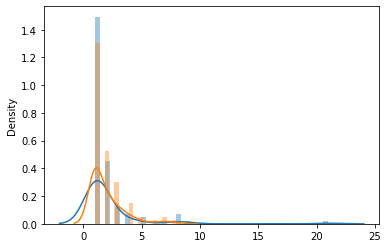

In [452]:
def plot_degree_dist(G, label):
    degrees = [G.degree(n) for n in G.nodes()]
    #plt.hist(degrees, label=label, density=True, alpha=0.5,bins=10)
    sns.distplot(degrees,label=label)
    

plot_degree_dist(mst_min, "min")
plot_degree_dist(mst_hour, "hour")
plt.show()

Yes. The plot above shows a similar degree distribution.